In [0]:
from collections import defaultdict
import gzip
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from functools import reduce
import nltk
nltk.download('conll2002')
from string import punctuation
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectFromModel,SelectKBest
from sklearn.feature_extraction import DictVectorizer
from sklearn.base import TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from gensim.models import KeyedVectors
from sklearn.pipeline import FeatureUnion

def flatten(lst):
    return list(map(lambda e:e[0],lst))

[nltk_data] Downloading package conll2002 to /home/yairzo/nltk_data...
[nltk_data]   Package conll2002 is already up-to-date!


## 1. Word Classification

### 1.1

In [0]:
#### Q1.1 Evaluation Metrics ####

## Input: y_pred, a list of length n with the predicted labels,
## y_true, a list of length n with the true labels

## Calculates the precision of the predicted labels
SIMPLE = 0
COMPLEX = 1


def get_precision(y_pred, y_true):
    # TP / (TP+FP)
    TP = 0
    FP = 0
    for pi, ti in zip(y_pred, y_true):
        if pi == ti == COMPLEX:  # TP
            TP += 1
        if pi == COMPLEX and ti == SIMPLE:
            FP += 1
    return TP / (TP + FP)


## Calculates the recall of the predicted labels
def get_recall(y_pred, y_true):
    # TP / (TP + FN)
    TP = 0
    FN = 0
    for pi, ti in zip(y_pred, y_true):
        if pi == ti == COMPLEX:  # TP
            TP += 1
        if pi == SIMPLE and ti == COMPLEX:
            FN += 1
    return TP / (TP + FN)


## Calculates the f-score of the predicted labels
def get_fscore(y_pred, y_true):
    precision = get_precision(y_pred, y_true)
    recall = get_recall(y_pred, y_true)
    return 2 * (precision * recall) / (precision + recall)

def test_predictions(y_pred, y_true):
    recall = get_recall(y_pred, y_true)
    precision = get_precision(y_pred, y_true)
    fscore = get_fscore(y_pred, y_true)
    print('-------------------------------')
    print('Recall = ' + str(recall))
    print('Precision = ' + str(precision))
    print('Fscore = ' + str(fscore))
    print('-------------------------------')

def print_scores(performance):
    precision, recall, fscore = performance
    print('Recall = ' + str(round(recall,3)))
    print('Precision = ' + str(round(precision,3)))
    print('Fscore = ' + str(round(fscore,3)))



### 1.2

In [0]:
def load_file(data_file):
    words = []
    labels = []
    with open(data_file, 'rt', encoding="utf8") as f:
        i = 0
        for line in f:
            if i > 0:
                line_split = line[:-1].split("\t")
                words.append(line_split[0].lower())
                labels.append(int(line_split[1]))
            i += 1
    return words, labels

test_file = '../data/complex_words_test_unlabeled.txt'
development_file = '../data/complex_words_development.txt'
training_file = '../data/complex_words_training.txt'

#### 1.2.1: A very simple baseline


In [0]:
## Labels every word complex
def all_complex(data_file):
    words, y_true = load_file(data_file)
    y_pred = [1] * len(words)
    recall = get_recall(y_pred, y_true)
    precision = get_precision(y_pred, y_true)
    fscore = get_fscore(y_pred, y_true)
    performance = [precision, recall, fscore]
   # test_predictions(y_pred, y_true)
    return performance


print_scores(all_complex(training_file))

Recall = 1.0
Precision = 0.433
Fscore = 0.604


As we can see, recall = 1 becuase we labeled all words as complex words

#### 1.2.2
We will find the best threshold’s performance on both the training and development data,
by finding the maximum fscore value on several thresholds. 

We will try to find the best threshold among $0...min\{max\{len_{train}(word_i)\},max\{len_{dev}(word_j)\}\}$ values. In a case that the threshold is equal or bigger then the maximum word length we will label all words as simple and the denominator of the precision which is all of the complex words that we have predicted will be zero. So we will choose the maximum threshold to be $min\{max\{len_{train}(word_i)\},max\{len_{dev}(word_j)\}\}$ 

In [0]:
train_precisions = []
train_recalls = []
dev_precisions = []
dev_recalls = []
    

def info_for_plotting(training_performance,development_performance):
    tprecision, trecall, tfscore = training_performance
    dprecision, drecall, dfscore = development_performance
    train_precisions.append(tprecision)
    train_recalls.append(trecall)
    dev_precisions.append(dprecision)
    dev_recalls.append(drecall)
    
def predict_by_threshold(t_words, t_y_true, d_words,d_y_true,threshold):
    performance_functions= [get_precision, get_recall, get_fscore]
    is_longer = lambda word: COMPLEX if len(word) > threshold else SIMPLE
    get_performance = lambda preds, labels: list(map(lambda f: f(preds, labels), performance_functions))
    
    t_prediction_labels = list(map(is_longer ,t_words))
    d_prediction_labels = list(map(is_longer ,d_words))

    return get_performance(t_prediction_labels, t_y_true), get_performance(d_prediction_labels, d_y_true)

def word_length_threshold(training_file, development_file):
    t_words, t_y_true = load_file(training_file)
    d_words, d_y_true = load_file(development_file)
    max_threshold = min(max(list(map(len,t_words))),max(list(map(len,d_words))))
    max_train_fscore = 0
    max_dev_fscore = 0
    best_train_performance = []
    best_dev_performance = []
    
    for threshold in range(0,max_threshold):
        training_performance, development_performance = predict_by_threshold(t_words, t_y_true,d_words, d_y_true,threshold)
        tprecision, trecall, tfscore = training_performance
        dprecision, drecall, dfscore = development_performance

        if tfscore>max_train_fscore:
            max_train_fscore = tfscore
            best_train_performance = [training_performance,threshold]
        if dfscore>max_dev_fscore:
            max_dev_fscore = dfscore
            best_dev_performance = [development_performance,threshold]
            
        #for plotting :
        info_for_plotting(training_performance,development_performance)

    return best_train_performance,best_dev_performance

In [0]:
train_info,dev_info = word_length_threshold(training_file,development_file)
train_performance , train_threshold = train_info
dev_performance , dev_threshold = dev_info
print('Train best threshold: ' + str(train_threshold))
print_scores(train_performance)
print()
print('Dev best threshold: ' + str(dev_threshold))
print_scores(dev_performance)

Train best threshold: 6
Recall = 0.844
Precision = 0.601
Fscore = 0.702

Dev best threshold: 6
Recall = 0.866
Precision = 0.605
Fscore = 0.713


Now, we will plot the Precision-Recall curve for the various thresholds that we have tried

/usr/local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


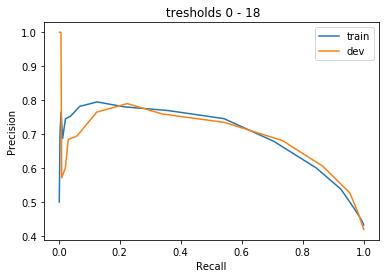

In [0]:
def plot_preision_recall(train_recalls,train_precisions,dev_recalls,dev_precisions,title=""): 
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(title)
    sns.lineplot(train_recalls, train_precisions,label='train') 
    sns.lineplot(dev_recalls,dev_precisions,label='dev')  
    plt.legend(loc='best')
    plt.show()
    
plot_preision_recall(train_recalls,train_precisions,dev_recalls,dev_precisions," tresholds 0 - 18")

As we expected, the plot above is representing the trade off between precision and recall.<br>
We can see that until a specific point the recall and the precision are improving but from this point as much as the recall $\to1$ then the precision $\to0$. <br>
Another thing that we can see at $treshhold = 18$ on the development set,  the recall is zero and the precision is 1 (perfect). That's means we taged all the words as ```SIMPLE```. Notice that it's expected because the maximum word length is$18$.
Also, we can see that the train and dev are behaving similarly.

#### 1.2.3: Word frequency thresholding

In [0]:
## Loads Google NGram counts
def load_ngram_counts(ngram_counts_file):
    counts = defaultdict(int)
    with gzip.open(ngram_counts_file, 'rt', errors='ignore') as f:
        for line in f:
            token, count = line.strip().split('\t')
            if token[0].islower():
                counts[token] = int(count)
    return counts

In [0]:
counts = load_ngram_counts('../data/ngram_counts.txt.gz')

We assume that complex words frequency will be smaller then simple words. 
So every word count that below threshold will be labeled as complex.

In [0]:

# Finds the best frequency threshold by f-score, and uses this threshold to
## classify the training and development set
def word_frequency_threshold(training_file, development_file, counts):
    t_words, t_y_true = load_file(training_file)
    d_words, d_y_true = load_file(development_file)
    count = lambda word : counts[word]
    max_threshold = min(max(list(map(count,t_words))),max(list(map(count,d_words))))
    min_threshold = max(min(list(map(count,t_words))),min(list(map(count,d_words))))
    
    max_train_fscore = 0
    max_dev_fscore = 0
    best_train_performance = []
    best_dev_performance = []
    
    for threshold in range(1000000,50000000, 10000):
        training_performance, development_performance = predict_by_threshold(t_words, t_y_true,d_words, d_y_true,counts,threshold)
        tprecision, trecall, tfscore = training_performance
        dprecision, drecall, dfscore = development_performance

        if tfscore>max_train_fscore:
            max_train_fscore = tfscore
            best_train_performance = [training_performance,threshold]
        if dfscore>max_dev_fscore:
            max_dev_fscore = dfscore
            best_dev_performance = [development_performance,threshold]
            
        #for plotting :
        info_for_plotting(training_performance,development_performance)
    return best_train_performance,best_dev_performance


def predict_by_threshold(t_words, t_y_true, d_words,d_y_true,counts,threshold):
    performance_functions= [get_precision, get_recall, get_fscore]
    is_longer = lambda word: COMPLEX if counts[word] < threshold else SIMPLE
    get_performance = lambda preds, labels: list(map(lambda f: f(preds, labels), performance_functions))
    
    t_prediction_labels = list(map(is_longer ,t_words))
    d_prediction_labels = list(map(is_longer ,d_words))

    return get_performance(t_prediction_labels, t_y_true), get_performance(d_prediction_labels, d_y_true)

In [0]:
# range(1000000,50000000, 10000)
train_info,dev_info = word_frequency_threshold(training_file,development_file,counts)
train_performance , train_threshold = train_info
dev_performance , dev_threshold = dev_info
print('Train best threshold: ' + str(train_threshold))
print_scores(train_performance)
print()
print('Dev best threshold: ' + str(dev_threshold))
print_scores(dev_performance)

Train best threshold: 19840000
Recall = 0.816
Precision = 0.566
Fscore = 0.668

Dev best threshold: 14880000
Recall = 0.811
Precision = 0.582
Fscore = 0.678


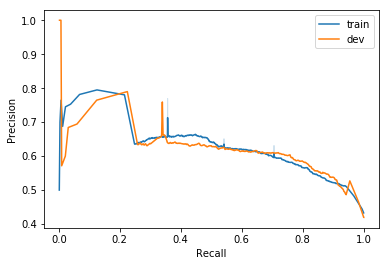

In [0]:
plot_preision_recall(train_recalls,train_precisions,dev_recalls,dev_precisions)

### 1.3. Classifiers

#### 1.3.1: Naive Bayes


In [0]:
def extract_features(words,counts):
    words_counts = list(map(lambda word:counts[word],words))
    words_length = list(map(len,words))
    X_train = zip(words_length,words_counts)
    return np.array(list(map(list,X_train)))
    
def norm(X,data):
    mean = np.mean(data,axis=0)
    std = np.std(data,axis=0)
    return (X-mean) / std

## Trains a Naive Bayes classifier using length and frequency features
def naive_bayes(training_file, development_file, counts):
    X_train,Y_train = load_file(training_file)
    X_dev, Y_dev = load_file(development_file)
    
    X_train = extract_features(X_train,counts)
    X_dev = extract_features(X_dev,counts)

    X_dev = norm(X_dev,X_train)
    X_train = norm(X_train,X_train)

    clf = GaussianNB()
    clf.fit(X_train, Y_train)
    
    performance_functions = [get_precision, get_recall, get_fscore]
    get_performance = lambda preds, labels: list(map(lambda f: f(preds, labels), performance_functions))
    train_preds = clf.predict(X_train)
    dev_preds = clf.predict(X_dev)
    return get_performance(train_preds,Y_train), get_performance(dev_preds,Y_dev)


In [0]:
train_info,dev_info = naive_bayes(training_file,development_file,counts)
print('Train')
print_scores(train_info)
print()
print('Dev')
print_scores(dev_info)

Train
Recall = 0.98
Precision = 0.495
Fscore = 0.658

Dev
Recall = 0.969
Precision = 0.469
Fscore = 0.632


Recall is getting better in this model but the precision is doing worse. This meas that the model is taggin more words as complex words then the two previous classifiers. But not in a "smart" way. I mean the model is getting colser to a naive classifer that tag all the words as complex.


### 1.4: Ambiguity


In [0]:
def load_file_with_context(data_file):
    words = []
    labels = []
    context = []
    with open(data_file, 'rt', encoding="utf8") as f:
        i = 0
        for line in f:
            if i > 0:
                line_split = line[:-1].split("\t")
                words.append(line_split[0].lower())
                labels.append(int(line_split[1]))
                context.append(line_split[3])
            i += 1
    return words, labels, context

def get_context_sensitive(words, y_true, contexts):
    map_words = {}
    for word, label, context in zip(words,y_true,contexts):
        if word in map_words:
            if map_words[word][0][0] != label:
                map_words[word].append([label,context])
        else:
            map_words[word] = [[label,context]]
    
    context_sensitive_words = {}
    for word,context in map_words.items():
        if len(context) > 1: # that's sensitive
            context_sensitive_words[word] = [context[0][1],context[1][1]]
    return pd.DataFrame.from_dict(context_sensitive_words)

In [0]:
words, y_true, contexts = load_file_with_context(training_file)

In [0]:
get_context_sensitive(words, y_true, contexts)

,campaign,element,inspired,district,commissioner,opponents,sprouts,league,hoverboard,slavery,indy
0,"`` Given the way the meeting transpired , '' R...","Element 118 , for example , is the heaviest el...",Miguel Castañeda started Tech Connect in 2009 ...,Now 80 and a resident of the Park La Brea comp...,"`` As we have indicated earlier , another laws...","`` I love droppin ' 'em , '' she says about op...",The scientists were initially skeptical about ...,"Tom Brady has been an NFL golden boy , with mo...","`` Hoverboard is on fire , '' he says in a vid...","Slavery was a `` side issue to the Civil War ,...","`` If you want to learn how to run Indy cars ,..."
1,The campaign around the Maine Bear Hunting Ban...,Arturo Sanchez is in his element .,"Inspired by their courage , demonstrators acro...","Before the jurors began their deliberations , ...",NFL Commissioner Roger Goodell said he issued ...,Opponents led by a group called Save Maine 's ...,"An apple can kill , a sprinkle of sprouts can ...","One piece of that market , e-sport multiplayer...",Timothy Cade had only owned his hoverboard for...,"And when it comes to the Civil War , children ...","`` If you want to learn how to run Indy cars ,..."


Let's look on the word 'campaign' which is context sensetive according to our code.<br>
This word occurs in two different contexts:
1. SIMPLE<br>
Given the way the meeting transpired,  Ray Halbritter , an Oneida representative and leader of the Change the Mascot ``Campaign``,  said Wednesday,  it became somewhat evident they were defending the continued use of the name.
2. COMPLEX<br>
The ``campaign`` around the Maine Bear Hunting Ban Initiative , which will appear on the ballot as Question 1 , has shed light on Maine 's unique status in the wildlife world 


## 2 Document Classification


### 2.1. Reuters Dataset

#### 2.1.1 
We will explore how many documents are in the dataset, how many categories, how many documents per categories, and will provide mean and standard deviation, min and max. 

In [0]:
from __future__ import print_function
from glob import glob
import itertools
import os.path
import re
import tarfile
import time
import sys

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

from sklearn.externals.six.moves import html_parser
from sklearn.externals.six.moves.urllib.request import urlretrieve
from sklearn.datasets import get_data_home
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import MultinomialNB


def _not_in_sphinx():
    # Hack to detect whether we are running by the sphinx builder
    return '__file__' in globals()

class ReutersParser(html_parser.HTMLParser):
    """Utility class to parse a SGML file and yield documents one at a time."""

    def __init__(self, encoding='latin-1'):
        html_parser.HTMLParser.__init__(self)
        self._reset()
        self.encoding = encoding

    def handle_starttag(self, tag, attrs):
        method = 'start_' + tag
        getattr(self, method, lambda x: None)(attrs)

    def handle_endtag(self, tag):
        method = 'end_' + tag
        getattr(self, method, lambda: None)()

    def _reset(self):
        self.in_title = 0
        self.in_body = 0
        self.in_topics = 0
        self.in_topic_d = 0
        self.title = ""
        self.body = ""
        self.topics = []
        self.topic_d = ""

    def parse(self, fd):
        self.docs = []
        for chunk in fd:
            self.feed(chunk.decode(self.encoding))
            for doc in self.docs:
                yield doc
            self.docs = []
        self.close()

    def handle_data(self, data):
        if self.in_body:
            self.body += data
        elif self.in_title:
            self.title += data
        elif self.in_topic_d:
            self.topic_d += data

    def start_reuters(self, attributes):
        pass

    def end_reuters(self):
        self.body = re.sub(r'\s+', r' ', self.body)
        self.docs.append({'title': self.title,
                          'body': self.body,
                          'topics': self.topics})
        self._reset()

    def start_title(self, attributes):
        self.in_title = 1

    def end_title(self):
        self.in_title = 0

    def start_body(self, attributes):
        self.in_body = 1

    def end_body(self):
        self.in_body = 0

    def start_topics(self, attributes):
        self.in_topics = 1

    def end_topics(self):
        self.in_topics = 0

    def start_d(self, attributes):
        self.in_topic_d = 1

    def end_d(self):
        self.in_topic_d = 0
        self.topics.append(self.topic_d)
        self.topic_d = ""


def stream_reuters_documents(data_path=None):
    """Iterate over documents of the Reuters dataset.

    The Reuters archive will automatically be downloaded and uncompressed if
    the `data_path` directory does not exist.

    Documents are represented as dictionaries with 'body' (str),
    'title' (str), 'topics' (list(str)) keys.

    """

    DOWNLOAD_URL = ('http://archive.ics.uci.edu/ml/machine-learning-databases/'
                    'reuters21578-mld/reuters21578.tar.gz')
    ARCHIVE_FILENAME = 'reuters21578.tar.gz'

    if data_path is None:
        data_path = os.path.join(get_data_home(), "reuters")
    if not os.path.exists(data_path):
        """Download the dataset."""
        print("downloading dataset (once and for all) into %s" %
              data_path)
        os.mkdir(data_path)

        def progress(blocknum, bs, size):
            total_sz_mb = '%.2f MB' % (size / 1e6)
            current_sz_mb = '%.2f MB' % ((blocknum * bs) / 1e6)
            if _not_in_sphinx():
                sys.stdout.write(
                    '\rdownloaded %s / %s' % (current_sz_mb, total_sz_mb))

        archive_path = os.path.join(data_path, ARCHIVE_FILENAME)
        urlretrieve(DOWNLOAD_URL, filename=archive_path,
                    reporthook=progress)
        if _not_in_sphinx():
            sys.stdout.write('\r')
        print("untarring Reuters dataset...")
        tarfile.open(archive_path, 'r:gz').extractall(data_path)
        print("done.")

    parser = ReutersParser()
    for filename in glob(os.path.join(data_path, "*.sgm")):
        for doc in parser.parse(open(filename, 'rb')):
            yield doc

Our own 'get_minibatch' returns list of tuples of the form (doc,[categories...]) by given batch_size 

In [0]:
import itertools

def get_minibatch(doc_iter, size):
    """Extract a minibatch of examples, return a tuple X_text, y.

    Note: size is before excluding invalid docs with no topics assigned.

    """

    data = [(u'{title}\n\n{body}'.format(**doc),doc['topics'])
            for doc in itertools.islice(doc_iter, size) if doc['topics'] ]
    return data


def iter_minibatches(doc_iter, minibatch_size):
    """Generator of minibatches."""
    doc_topics_list = get_minibatch(doc_iter, minibatch_size)
    while len(doc_topics_list):
        yield doc_topics_list
        doc_topics_list = get_minibatch(doc_iter, minibatch_size)

We are counting every time that category occurs in a given document with a collections.counter

In [0]:
from collections import defaultdict,Counter
category_counter = Counter()
download_path = '../data/reuters'
doc_iter = stream_reuters_documents(download_path)
minibatch_size = 1000
for batch in iter_minibatches(doc_iter,minibatch_size):
    for (doc,categories) in batch:
        for cat in categories:
            category_counter[cat]+=1
            
category_counter = dict(category_counter)
number_of_categories  = len(category_counter.keys())
categories_count_df = pd.DataFrame(category_counter,index=[0]).T
categories_count_df.columns = ['count']

In [0]:
number_of_docs = 0
doc_iter = stream_reuters_documents(download_path)
for doc in doc_iter:
    number_of_docs += 1

In [0]:
print("Number of documents " + str(number_of_docs))
exploration_info = categories_count_df.describe()
exploration_info.index.values[0] = 'Number of categories (count)'
exploration_info

Number of documents 21578


,count
Number of categories (count),445.000000
mean,89.871910
std,644.656909
min,1.000000
25%,3.000000
50%,8.000000
75%,37.000000
max,12542.000000


#### 2.1.2
Let's count many characters and words are present in the documents of the dataset.


We will count distinct words (no punctuations and spaces) 

In [0]:
distinct_words = []
number_of_words = 0
number_of_chars = 0
def words(text): return re.findall(r'\w+', text.lower())

def get_distinct_words(doc):
    return set(words(doc))
    
doc_iter = stream_reuters_documents(download_path)
for doc in doc_iter:
    doc = u'{title}\n\n{body}\n{topics}'.format(**doc)
    number_of_chars += len(doc)
    number_of_words += len(words(doc))
    distinct_words += get_distinct_words(doc)
distinct_words = set(distinct_words)
distinct_chars = set()
for word in distinct_words:
    distinct_chars = distinct_chars.union(set(word))  #split to chars
distinct_chars = set(distinct_chars)

In [0]:
print('Number of words {:,}'.format(number_of_words))
print('Number of chars {:,}'.format(number_of_chars))
print('Number of distinct words {:,}'.format(len(distinct_words)))
print('Number of distinct chars {:,}'.format(len(distinct_chars)))

Number of words 2,910,221
Number of chars 16,864,532
Number of distinct words 45,422
Number of distinct chars 38


#### 2.1.3
The classifiers that support the "partial-fit" method are.


Scikit-learn can be used for classification or other predictions tasks using an out-of-core approach: learning from data that doesn’t fit into main memory by using partial_fit method.<br>
partial_fit method will fit online or incremental learning algorithms, because this algorithms can train on a dataset by small batch in each iteration. this allows out-of-core learning.<br>
The following algorithms support the partial_fit method :<br>
>Classification
- sklearn.naive_bayes.MultinomialNB
- sklearn.naive_bayes.BernoulliNB
- sklearn.linear_model.Perceptron
- sklearn.linear_model.SGDClassifier
- sklearn.linear_model.PassiveAggressiveClassifier

>Regression
- sklearn.linear_model.SGDRegressor
- sklearn.linear_model.PassiveAggressiveRegressor

>Clustering
- sklearn.cluster.MiniBatchKMeans

>Decomposition / feature Extraction
- sklearn.decomposition.MiniBatchDictionaryLearning
- sklearn.decomposition.IncrementalPCA
- sklearn.cluster.MiniBatchKMeans


Further information about the classifiers that used in the given code: <br>

1. ```SGD Classifier```: 

> This estimator implements regularized linear models with stochastic gradient descent (SGD) learning: the gradient of the loss is estimated each sample at a time and the model is updated along the way with a learning rate:
\begin{align}
w & = w-\eta\nabla Q_i(w) 
\end{align}
In pseudocode, stochastic gradient descent can be presented as follows:
    1. Choose an initial vector of parameters w  and learning rate eta.
    2. Repeat until an approximate minimum is obtained:
    3. Randomly shuffle examples in the training set.
    4. For i=1,2,...,n , do:
\begin{align}
w & = w-\eta\nabla Q_i(w) 
\end{align}
It is called stochastic because samples are selected randomly (or shuffled) instead of as a single group (as in standard gradient descent) or in the order they appear in the training set.
SGD allows minibatch (online/out-of-core) learning.

2. ```PassiveAggressive Classifier```: 

> Passive Aggressive Algorithm is an online learning algorithms, for both classification and regression. We will focus on the binary classification part. Where the targets are in $[-1, 1]$.
Given a weight vector $w$, the prediction is simply:
\begin{align}
predY_t = sign(w^T \cdot{} x_t)
\end{align}
In addition the algorithm use the Hinge loss function:
\begin{align}
L(θ) = max(0, 1-y_t f(x_t, θ))
\end{align}
Where $θ$ is the degree between $x_t$ and $w_t$
A Passive-Aggressive algorithm works with the following update rule:
\begin{align}
w_{t+1} = w_t + \frac{max(0, 1-predY_t(w^T \cdot{} x_t)}{||x_t||^2 + \frac{1}{2C}} y_t x_t
\end{align}
Note that if there’s no misclassification the nominator becomes $0$, so $w_{t+1} = w_t$.  This means that the algorithm is ***passive*** when a correct classification occurs. While, in case of misclassification, $w$ will rotate towards $x_t$. This shows that the update rule becomes very ***aggressive***. In order to allow a degree of tolerance controlled we use the parameter $C$ and stops the rotation with a loss $L <= ξ$.

3. ```Perceptron```: 

>This model takes an input, aggregates it (weighted sum) and returns 1 only if the aggregated sum is more than some threshold else returns 0.<br> 
Updating the weights will preformed by iterations with the next formula:<br>
$r$ is the learning rate<br>
$d_j$ desired output <br>
$x _j$ input <br>
$y_j$ model prediction<br>
for all features $0<=i<=n$:
\begin{align}
 w_{i}(t+1)=w_{i}(t)+r(d_{j} - y_{j}(t))x_{j,i}
\end{align}
<br>
For offline learning, $y_j$ calculation and weights upadate steps may be repeated until the iteration error MAE
is less than a user-specified error threshold.<br>
If the training set is linearly separable, then the perceptron is guaranteed to converge. Furthermore, there is an upper bound on the number of times the perceptron will adjust its weights during the training.


4. ```MultinomialNB```: 

> Naive Bayes classifier for multinomial models
The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts.

#### 2.1.4
To guarantee that the features space remains the same over time the given code leverage a HashingVectorizer that project each example into the same feature space.<br>
It turns a collection of text documents into a matrix holding token occurrence counts.<br>
This is especially useful in the case of text classification where new features (words) may appear in each batch and early fitting would be wrong.<br>
For exmaple, if we would like to use BoW as a representation for each batch the number of features will likely to be different for each batch.

### 2.2 Spam Dataset

In [0]:
%matplotlib inline
import os
import sys
import numpy
from pandas import DataFrame
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, f1_score

def progress(i, end_val, bar_length=50):
    '''
    Print a progress bar of the form: Percent: [#####      ]
    i is the current progress value expected in a range [0..end_val]
    bar_length is the width of the progress bar on the screen.
    '''
    percent = float(i) / end_val
    hashes = '#' * int(round(percent * bar_length))
    spaces = ' ' * (bar_length - len(hashes))
    sys.stdout.write("\rPercent: [{0}] {1}%".format(hashes + spaces, int(round(percent * 100))))
    sys.stdout.flush()

NEWLINE = '\n'
HAM = 'ham'
SPAM = 'spam'

SOURCES = [
    ('../data/spam/spam',        SPAM),
    ('../data/spam/easy_ham',    HAM),
    ('../data/spam/hard_ham',    HAM),
    ('../data/spam/beck-s',      HAM),
    ('../data/spam/farmer-d',    HAM),
    ('../data/spam/kaminski-v',  HAM),
    ('../data/spam/kitchen-l',   HAM),
    ('../data/spam/lokay-m',     HAM),
    ('../data/spam/williams-w3', HAM),
    ('../data/spam/BG',          SPAM),
    ('../data/spam/GP',          SPAM),
    ('../data/spam/SH',          SPAM)
]

SKIP_FILES = {'cmds'}


def read_files(path):
    '''
    Generator of pairs (filename, filecontent)
    for all files below path whose name is not in SKIP_FILES.
    The content of the file is of the form:
        header....
        <emptyline>
        body...
    This skips the headers and returns body only.
    '''
    for root, dir_names, file_names in os.walk(path):
        for path in dir_names:
            read_files(os.path.join(root, path))
        for file_name in file_names:
            if file_name not in SKIP_FILES:
                file_path = os.path.join(root, file_name)
                if os.path.isfile(file_path):
                    past_header, lines = False, []
                    f = open(file_path, encoding="latin-1")
                    for line in f:
                        if past_header:
                            lines.append(line)
                        elif line == NEWLINE:
                            past_header = True
                    f.close()
                    content = NEWLINE.join(lines)
                    yield file_path, content


def build_data_frame(l, path, classification):
    rows = []
    index = []
    for i, (file_name, text) in enumerate(read_files(path)):
        if ((i+l) % 100 == 0):
            progress(i+l, 58910, 50)
        rows.append({'text': text, 'class': classification})
        index.append(file_name)
   
    data_frame = DataFrame(rows, index=index)
    return data_frame, len(rows)

def load_data():
    data = DataFrame({'text': [], 'class': []})
    l = 0
    for path, classification in SOURCES:
        data_frame, nrows = build_data_frame(l, path, classification)
        data = data.append(data_frame, sort=False)
        l += nrows
    data = data.reindex(numpy.random.permutation(data.index))
    return data

In [0]:
data = load_data()

Percent: [##################################################] 100%

In [0]:
data.describe()

,text,class
count,58910,58910
unique,52936,2
top,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 3.2//E...",spam
freq,93,35371


In [0]:
vectorizer = CountVectorizer(ngram_range=(1,2))
fit_info = vectorizer.fit(data['text'].values,data['class'].values)
features = vectorizer.get_feature_names()
number_of_unigrams = reduce(lambda acc,cur: acc + 1 if ' ' not in cur else acc,features,0)
number_of_bigrams = len(features) - number_of_unigrams

#### 2.2.1

In [0]:
print('Number of unigrams {:,}'.format(number_of_unigrams))
print('Number of bigrams {:,}'.format(number_of_bigrams))

Number of unigrams 697,570
Number of bigrams 3,318,380


We can see that the bigrams number is bigger the unigrams, because unigrams is equal to number of distinct words and the probability that bigrams occurs will repeat in the data is less then unigram.

#### 2.2.2

In [0]:
import operator
def split_unigram_bigram(data,n=50):
    vectorizer = CountVectorizer(ngram_range=(1,2))
    fit_info = vectorizer.fit(data['text'].values,data['class'].values)
    bigram_freq = {}
    unigram_freq = {}
    voc = fit_info.vocabulary_
    for word,count in voc.items():
        if ' ' in word:
            bigram_freq[word] = count
        else:
            unigram_freq[word] = count
    return unigram_freq, bigram_freq

def dict_to_sorted_df(dict_to_sort):
    soted_dict = [(k, dict_to_sort[k]) for k in sorted(dict_to_sort, key=dict_to_sort.get, reverse=True)]
    return pd.DataFrame.from_dict(dict(soted_dict[:50]),orient='index',columns=['count'])


In [0]:
unigram_freq, bigram_freq = split_unigram_bigram(data)
print('The 50 most common unigrams are ')
print(dict_to_sorted_df(unigram_freq))
print()
print('The 50 most common bigrams are ')
print(dict_to_sorted_df(bigram_freq))


The 50 most common unigrams are 
                                              count
ÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿó  4015948
ÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿô        4015946
ÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿò        4015944
ÿÿã                                         4015941
ÿÿ                                          4015939
ÿò                                          4015937
þüg                                         4015935
þööööà                                      4015933
þöyledir                                    4015931
þö                                          4015929
þõµ                                         4015927
þòº                                         4015925
þïøã                                        4015923
þïñ                                         4015921
þîñõ¹àà                                     4015919
þîñæ                                        4015916
þîñäüîªäúµäéú                               4015914
þîñ                            

##### Since the dataset is unbalanced with more spam samples then ham we can see that the 50 common uni\bigrams looks like spam

#### 2.2.3

In [0]:
spam_data = data.loc[data['class'] == SPAM]
ham_data = data.loc[data['class'] == HAM]

In [0]:
unigram_freq, bigram_freq = split_unigram_bigram(spam_data)
print('The 50 most common unigrams are ')
print(dict_to_sorted_df(unigram_freq))
print()
print('The 50 most common bigrams are ')
print(dict_to_sorted_df(bigram_freq))

In [0]:
unigram_freq, bigram_freq = split_unigram_bigram(ham_data)
print('The 50 most common unigrams are ')
print(dict_to_sorted_df(unigram_freq))
print()
print('The 50 most common bigrams are ')
print(dict_to_sorted_df(bigram_freq))

The 50 most common unigrams are 
                                                      count
überzeugen                                          1444162
übernehmen                                          1444160
über                                                1444156
örnsköldsvik                                        1444154
öffnender                                           1444152
öcalan                                              1444147
ñîçíàíèÿ                                            1444145
être                                                1444143
été                                                 1444141
étatiques                                           1444139
était                                               1444137
étaient                                             1444135
épineux                                             1444133
élite                                               1444131
éliminé                                             1444128
éibhear

#### 2.2.4

In [0]:
train_text = data['text'].values
y_train = data['class'].values.astype(str)
vectorizer = CountVectorizer(ngram_range=(1, 2))
x_train = vectorizer.fit_transform(train_text)
feature_names = vectorizer.get_feature_names()

In [0]:
nbm = SelectFromModel(MultinomialNB())
nbm.fit(x_train,y_train)

SelectFromModel(estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
        max_features=None, norm_order=1, prefit=False, threshold=None)

In the binary case, coef_ is flattened to save space.<br>
The coef_ attribute of MultinomialNB is a re-parameterization of the naive Bayes model as a linear classifier model.<br>
For our binary classification problem this is basically the log of the estimated probability of a feature given the positive class. It means that higher values mean more important features for the spam class.
Therefore, we will take the highest 20 values in coeff_ as the best 20 spam features and the lowest 20 values in coeff_ as the best 20 ham features.

In [0]:
# sorted_coeff = sorted(list(nbm.estimator_.coef_[0]),reverse=True)
enum_coeff = list(enumerate(nbm.estimator_.coef_[0]))
sorted_coeff = sorted(enum_coeff, key=lambda tup: tup[1],reverse=True)

best_20_spam_features = [feature_names[i] for (i,_) in sorted_coeff[:20]]
best_20_ham_features = [feature_names[i] for (i,_) in sorted_coeff[-20:]]

In [0]:
print("Best 20 features for spam")
print('-'*25)
print('\n'.join(best_20_spam_features))
print()
print("Best 20 features for ham")
print('-'*25)
print('\n'.join(best_20_ham_features))

Best 20 features for spam
-------------------------
font
3d
br
td
nbsp
the
size
tr
to
20
http
and
nbsp nbsp
width
of
br br
face
border
style
span

Best 20 features for ham
-------------------------
était pas
étatiques
étatiques the
été condamné
être la
ñîçíàíèÿ
ñîçíàíèÿ http
öcalan
öcalan avait
öcalan considered
öcalan considéré
öcalan had
öffnender
öffnender strukturen
örnsköldsvik
örnsköldsvik sweden
über den
über diesem
übernehmen
übernehmen wir


#### 2.2.5 

1. Normalization shouldn't be necessary since the features are only compared to each other.
$p(class|thing) = p(class)p(thing|class) =
= p(class)p(feature_1|class)p(feature_2|class)...p(feature_N|class)$
So when fitting the parameters for the distribution $feature_i|class$ it will just rescale the parameters (for the new "scale") in this case $(	\mu, \sigma^2)$, but the probabilities will remain the same.<br>


2. We do expect Logistic Regression to perform better with the new feature.<br>
Naive Bayes based on  strong independence assumptions between the features.<br>
As we can see in the plot and the table at the end of the attached notebook - spam is longer than ham on average, Also some of the features (words) as we saw in section 2.2.3 will defined the message as spam or ham which have a connection to the message length.<br>
According to this, we can see dependency between words and message length contrary to the Naive Bayes assumption.

#### 2.2.6

In [0]:
class Length_extractor(TransformerMixin):
    def transform(self,X):
        return np.array([[len(msg) for msg in X]]).T

    def fit(self,X,y=None):
        return self

def build_pipeline():
    pipeline = Pipeline([
          ('features', FeatureUnion([('vectorizer', CountVectorizer(ngram_range=(1,2))),
                                    ('length', Length_extractor())])),
        ('classifier',MultinomialNB())
    ])
    return pipeline

def train(data = None, n_folds = 6):
    if data is None:
        print("Loading data...")
        data = load_data()
        print("Data loaded")
    k_fold = KFold(n_splits = n_folds)
    pipeline = build_pipeline()
    scores = []
    confusion = numpy.array([[0, 0], [0, 0]])
    print("Training with %d folds" % n_folds)
    for i, (train_indices, test_indices) in enumerate(k_fold.split(data)):
        train_text = data.iloc[train_indices]['text'].values
        train_y = data.iloc[train_indices]['class'].values.astype(str)

        test_text = data.iloc[test_indices]['text'].values
        test_y = data.iloc[test_indices]['class'].values.astype(str)

        print("Training for fold %d" % i)
        pipeline.fit(train_text, train_y)
        print("Testing for fold %d" % i)
        predictions = pipeline.predict(test_text)

        confusion += confusion_matrix(test_y, predictions)
        score = f1_score(test_y, predictions, pos_label=SPAM)
        scores.append(score)
        print("Score for %d: %2.2f" % (i, score))
        print("Confusion matrix for %d: " % i)
        print(confusion)

    print('Total emails classified:', len(data))
    print('Score:', sum(scores)/len(scores))
    print('Confusion matrix:')
    print(confusion)
    return pipeline

In [0]:
pipeline_nb = train(data)

Training with 6 folds
Training for fold 0
Testing for fold 0
Score for 0: 0.98
Confusion matrix for 0: 
[[3900   16]
 [ 226 5677]]
Training for fold 1
Testing for fold 1
Score for 1: 0.98
Confusion matrix for 1: 
[[ 7780    41]
 [  442 11375]]
Training for fold 2
Testing for fold 2
Score for 2: 0.98
Confusion matrix for 2: 
[[11645    56]
 [  644 17111]]
Training for fold 3
Testing for fold 3
Score for 3: 0.98
Confusion matrix for 3: 
[[15558    76]
 [  813 22827]]
Training for fold 4
Testing for fold 4
Score for 4: 0.98
Confusion matrix for 4: 
[[19518   102]
 [  986 28486]]
Training for fold 5
Testing for fold 5
Score for 5: 0.98
Confusion matrix for 5: 
[[23423   116]
 [ 1241 34130]]
Total emails classified: 58910
Score: 0.9805063441613311
Confusion matrix:
[[23423   116]
 [ 1241 34130]]


In [0]:
def build_pipeline2():
    pipeline = Pipeline([
          ('features', FeatureUnion([('vectorizer', CountVectorizer(ngram_range=(1,2))),
                                    ('length', Length_extractor())])),
        ('classifier',LogisticRegression(solver='lbfgs'))
    ])
    
    LogisticRegression(solver='lbfgs')
    return pipeline
def train2(data = None, n_folds = 4):
    if data is None:
        print("Loading data...")
        data = load_data()
        print("Data loaded")
    k_fold = KFold(n_splits = n_folds)
    pipeline = build_pipeline2()
    scores = []
    confusion = numpy.array([[0, 0], [0, 0]])
    print("Training with %d folds" % n_folds)
    for i, (train_indices, test_indices) in enumerate(k_fold.split(data)):
        train_text = data.iloc[train_indices]['text'].values
        train_y = data.iloc[train_indices]['class'].values.astype(str)
        test_text = data.iloc[test_indices]['text'].values
        test_y = data.iloc[test_indices]['class'].values.astype(str)
        
        print("Training for fold %d" % i)
        pipeline.fit(train_text, train_y)
        print("Testing for fold %d" % i)
        predictions = pipeline.predict(test_text)
        
        confusion += confusion_matrix(test_y, predictions)
        score = f1_score(test_y, predictions, pos_label=SPAM)
        scores.append(score)
        
        print("Score for %d: %2.2f" % (i, score))
        print("Confusion matrix for %d: " % i)
        print(confusion)

    print('Total emails classified:', len(data))
    print('Score:', sum(scores)/len(scores))
    print('Confusion matrix:')
    print(confusion)
    return pipeline
    confusion = confusion_matrix(test_y, predictions)
    score = f1_score(test_y, predictions, pos_label=SPAM)
    print("Score for %d: %2.2f" % (i, score))
    print("Confusion matrix for %d: " % i)
    print(confusion)
    print('Total emails classified:', len(test_text))
    return pipeline

For Logistic Regression.


In [0]:
pipeline = train2(data)

Training with 4 folds
Training for fold 0


/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Testing for fold 0
Score for 0: 0.95
Confusion matrix for 0: 
[[5615  249]
 [ 589 8275]]
Training for fold 1


/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Testing for fold 1
Score for 1: 0.95
Confusion matrix for 1: 
[[11221   480]
 [ 1153 16602]]
Training for fold 2


/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Testing for fold 2
Score for 2: 0.96
Confusion matrix for 2: 
[[16936   698]
 [ 1558 24991]]
Training for fold 3


/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Testing for fold 3
Score for 3: 0.95
Confusion matrix for 3: 
[[22620   919]
 [ 2176 33195]]
Total emails classified: 58910
Score: 0.9554489528619319
Confusion matrix:
[[22620   919]
 [ 2176 33195]]


Actually we expected to have better results.<br>
For Naive Bayes descrease from 0.9947... to 0.9805... and for logistic regression from 0.9784... to 0.9554. 

## 3 Named Entity Recognition

In [0]:
from nltk.corpus import conll2002

etrain = list(nltk.corpus.conll2002.iob_sents('esp.train'))
etesta = list(nltk.corpus.conll2002.iob_sents('esp.testa'))
etestb = list(nltk.corpus.conll2002.iob_sents('esp.testb'))

dtrain = list(nltk.corpus.conll2002.iob_sents('ned.train'))
dtesta = list(nltk.corpus.conll2002.iob_sents('ned.testa'))
dtestb = list(nltk.corpus.conll2002.iob_sents('ned.testb'))

### 3.1

#### 3.1.1 Feature Extraction

Intermediate steps of the pipeline must be ‘transforms’, that is, they must implement fit and transform methods.

In [0]:
# list of features that have been found appropriate for NER 
# =========================================================
# The word form (the string as it appears in the sentence)
# The POS of the word (which is provided in the dataset)
# ORT - a feature that captures the orthographic (letter) structure of the word. It can have any of the following 
# values: number, contains-digit, contains-hyphen, capitalized, all-capitals, URL, punctuation, regular.
# prefix1: first letter of the word
# prefix2: first two letters of the word
# prefix3: first three letters of the word
# suffix1: last letter of the word
# suffix2: last two letters of the word
# suffix3: last three letters of the word

class NER_Features(TransformerMixin):
    def transform(self,X):
        all_features = []
        for s in X:
            all_features += self.sent2features(s)
        return all_features

    def fit(self,X,y=None):
        return self
    
    def sent2features(self,sent):
        return [word2features(sent, i) for i in range(len(sent))]
    
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]
    features = {
        'word_form' : word,
        'postag' : postag,
        'prefix1' : get_char_at(word,0),
        'prefix2' : get_char_at(word,1),
        'prefix3' : get_char_at(word,2),
        'suffix1' : get_char_at(word,-1),
        'suffix2' : get_char_at(word,-2),
        'suffix3' : get_char_at(word,-3),
        'ort': get_ort(word)}
    return features
        
def isContainDigit(s):
    return any(j.isdigit() for j in s)
  
def is_all_captialized(word):
    return all(map(lambda w:w.isupper(),list(word)))
    
def get_ort(word):
    ort_opt = {
    'number' : word.isnumeric(),
    'contains_digit' : isContainDigit(word),
    'contains_hyphen' : '-' in word,
    'capitalized' : word[0].isupper(),
    'all_capitals' : is_all_captialized(word),
    'punctuation' : str(word in punctuation)} # string.punctuation (imported)
    for ort,isOrt in ort_opt.items():
        if isOrt:
            return ort
    return 'regular'
    
    
def get_char_at(word,i):
    if abs(i) >= len(word): return ''
    else: return word[i]


def sent2labels(sent):
    return [label for token, postag, label in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent] 

def extract_labels(data):
    labels = []
    for sent in data:
        labels += sent2labels(sent)
    return labels
  
def encode_labels(data):
    Y_train = extract_labels(data)
    return LabelEncoder().fit(Y_train)

In [0]:
def create_pipeline():
    return Pipeline([('extract_features', NER_Features()),
                     ('vectorize', DictVectorizer())])

In [0]:
pipeline = create_pipeline()
label_encoder = encode_labels(etrain)

***Spanish dataset pre-process***


In [0]:
X_train_esp = pipeline.fit_transform(etrain)
Y_train_esp = label_encoder.fit_transform(extract_labels(etrain))

In [0]:
X_dev_esp = pipeline.transform(etesta)
Y_dev_esp = label_encoder.transform(extract_labels(etesta))

In [0]:
X_test_esp = pipeline.transform(etestb)
Y_test_esp = label_encoder.transform(extract_labels(etestb))

***Dutch dataset pre-process***


In [0]:
pipeline = create_pipeline()
label_encoder = encode_labels(dtrain)

In [0]:
X_train_du = pipeline.fit_transform(dtrain)
Y_train_du = label_encoder.fit_transform(extract_labels(dtrain))

In [0]:
X_dev_du = pipeline.transform(dtesta)
Y_dev_du = label_encoder.transform(extract_labels(dtesta))

In [0]:
X_test_du = pipeline.transform(dtestb)
Y_test_du = label_encoder.transform(extract_labels(dtestb))

#### 3.1.2 Now we will use a logistic regression classifier and some  experiments

Regularization is a very important technique in machine learning to prevent overfitting. Mathematically speaking, it adds a regularization term in order to prevent the coefficients to fit so perfectly to overfit.
In our case, one of logistic regression classifier parameter is C.<br>
C : Inverse of regularization strength.
We will use the development phase for finding optimal C  for our model.

In [0]:
def get_best_model_param(X_train, y_train, X_dev, y_dev):
    c_range = [0.001,0.01,0.1,1,10,100]
    scores = []
    for c in c_range:
        clf = LogisticRegression(C=c,solver='warn',multi_class='auto').fit(X_train, y_train)
        scores.append(clf.score(X_dev,y_dev))

    return c_range[np.argmax(scores)],c_range,scores

In [0]:
es_optimal_c, es_c_range, es_models_scores = get_best_model_param(X_train_esp,Y_train_esp,X_dev_esp,Y_dev_esp)

In [0]:
du_optimal_c, du_c_range, du_models_scores = get_best_model_param(X_train_du,Y_train_du,X_dev_du,Y_dev_du)

In [0]:
print("Optimal c for Spanish: " + str(es_optimal_c) + ' with score ' + str(round(max(es_models_scores),5)))
print("Optimal c for Dutch: " + str(du_optimal_c) + ' with score ' + str(round(max(du_models_scores),5)))

Optimal c for Spanish: 10 with score 0.93203
Optimal c for Dutch: 10 with score 0.9516


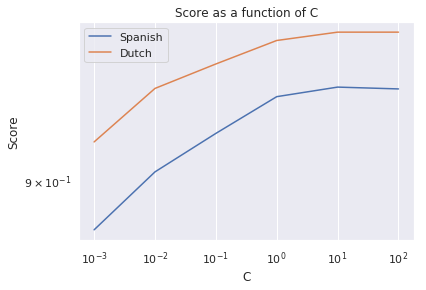

In [0]:
plt.grid(True)
plt.title('Score as a function of C')
plt.xlabel('C')
plt.ylabel('Score')
plt.loglog(es_c_range,es_models_scores)
plt.loglog(du_c_range,du_models_scores)

plt.legend(['Spanish', 'Dutch'], loc='best');

Better results for the Dutch dataset.

***Now, let's see the results on the test.***

1. Spanish dataset:

In [0]:
clf = LogisticRegression(C=es_optimal_c,solver='warn',multi_class='auto').fit(X_train_esp, Y_train_esp)
esp_test_score = clf.score(X_test_esp,Y_test_esp)
test_predictions = clf.predict(X_test_esp)

In [0]:
def show_confusion_matrix(Y_test_esp,test_predictions):
    classes = label_encoder.classes_
    range_of_classes = list(range(len(label_encoder.classes_)))
    sns.heatmap(confusion_matrix(Y_test_esp,test_predictions),cmap='Greens',annot=True, fmt='d')
    plt.xlabel('Prediction')
    plt.ylabel('True label')
    plt.title('LogisticRegression model \n classification results on test set')
    plt.xticks(range_of_classes, classes, rotation=45)
    plt.yticks(range_of_classes, classes,rotation=0)
    plt.show()

Spanish test results 0.9447


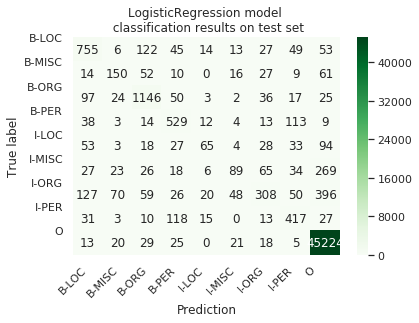

In [0]:
# from sklearn.metrics import precision_recall_fscore_support
print("Spanish test results " + str(round(esp_test_score,5)))
show_confusion_matrix(Y_test_esp,test_predictions)

2. Dutch dataset:

In [0]:
clf = LogisticRegression(C=du_optimal_c,solver='warn',multi_class='auto').fit(X_train_du, Y_train_du)
du_test_score = clf.score(X_test_du,Y_test_du)
du_test_predictions = clf.predict(X_test_du)

Dutch test results 0.95985


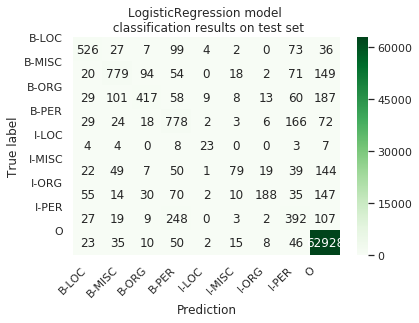

In [0]:
print("Dutch test results " + str(round(du_test_score,5)))
show_confusion_matrix(Y_test_du,du_test_predictions)

***Now we will improve our features set by looking at the tags of the previous word and the following word.***

In [0]:
def word2featuresExtented(sent, i):
    word = sent[i][0]
    postag = sent[i][1]
    features = {
        'word_form' : word,
        'postag' : postag,
        'prefix1' : get_char_at(word,0),
        'prefix2' : get_char_at(word,1),
        'prefix3' : get_char_at(word,2),
        'suffix1' : get_char_at(word,-1),
        'suffix2' : get_char_at(word,-2),
        'suffix3' : get_char_at(word,-3),
        'ort': get_ort(word)}
    if i > 0:
        prev_word, prev_tag, _ = sent[i-1]
        features['prev_word'] = prev_word
        features['prev_tag'] = prev_tag
    else:
        features['prev_word'] = 'BOF'
    if i < len(sent) - 1:
        next_word, next_tag,_ = sent[i+1]
        features['next_word'] = next_word
        features['next_tag'] = next_tag
    else:
        features['next_word'] = 'EOF'

    return features

def sent2features(self,sent):
    return [word2featuresExtented(sent, i) for i in range(len(sent))]

Updating NER_Features and then we will repeat the all process

In [0]:
setattr(NER_Features, 'sent2features', sent2features)

In [0]:
pipeline = create_pipeline()
label_encoder = encode_labels(etrain)

X_train_esp = pipeline.fit_transform(etrain)
Y_train_esp = label_encoder.fit_transform(extract_labels(etrain))

X_dev_esp = pipeline.transform(etesta)
Y_dev_esp = label_encoder.transform(extract_labels(etesta))

X_test_esp = pipeline.transform(etestb)
Y_test_esp = label_encoder.transform(extract_labels(etestb))

pipeline = create_pipeline()
label_encoder = encode_labels(dtrain)

X_train_du = pipeline.fit_transform(dtrain)
Y_train_du = label_encoder.fit_transform(extract_labels(dtrain))

X_dev_du = pipeline.transform(dtesta)
Y_dev_du = label_encoder.transform(extract_labels(dtesta))

X_test_du = pipeline.transform(dtestb)
Y_test_du = label_encoder.transform(extract_labels(dtestb))

In [0]:
es_optimal_c, es_c_range, es_models_scores = get_best_model_param(X_train_esp,Y_train_esp,X_dev_esp,Y_dev_esp)

In [0]:
du_optimal_c, du_c_range, du_models_scores = get_best_model_param(X_train_du,Y_train_du,X_dev_du,Y_dev_du)

In [0]:
print("Optimal c for Spanish: " + str(es_optimal_c) + ' with score ' + str(round(max(es_models_scores),5)))
print("Optimal c for Dutch: " + str(du_optimal_c) + ' with score ' + str(round(max(du_models_scores),5)))

Optimal c for Spanish: 100 with score 0.95221
Optimal c for Dutch: 100 with score 0.96861


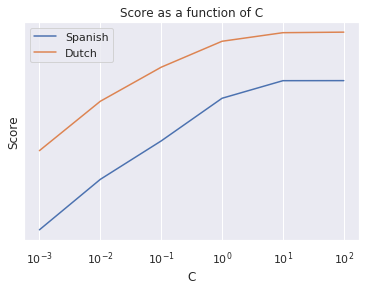

In [0]:
plt.grid(True)
plt.title('Score as a function of C')
plt.xlabel('C')
plt.ylabel('Score')
plt.loglog(es_c_range,es_models_scores)
plt.loglog(du_c_range,du_models_scores)

plt.legend(['Spanish', 'Dutch'], loc='best');

So there is a nice improvment, for the Spanish set (on dev) there is growth from $0.93203 \to 0.95221$ <br>
and for the Dutch $0.9516 \to 0.96861$<br>


***Now, let's see the results on the test.***


1. Spanish dataset:

In [0]:
clf = LogisticRegression(C=es_optimal_c,solver='warn',multi_class='auto').fit(X_train_esp, Y_train_esp)
esp_test_score = clf.score(X_test_esp,Y_test_esp)
test_predictions = clf.predict(X_test_esp)

Spanish test results 0.96162


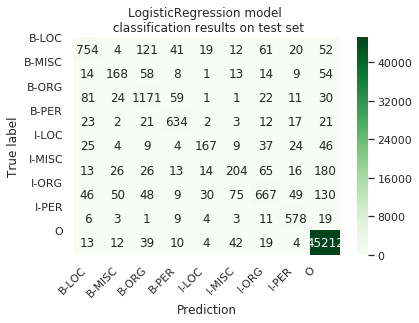

In [0]:
print("Spanish test results " + str(round(esp_test_score,5)))
show_confusion_matrix(Y_test_esp,test_predictions)

2. Dutch dataset:

In [0]:
clf = LogisticRegression(C=du_optimal_c,solver='warn',multi_class='auto').fit(X_train_du, Y_train_du)
du_test_score = clf.score(X_test_du,Y_test_du)
du_test_predictions = clf.predict(X_test_du)

Dutch test results 0.97509


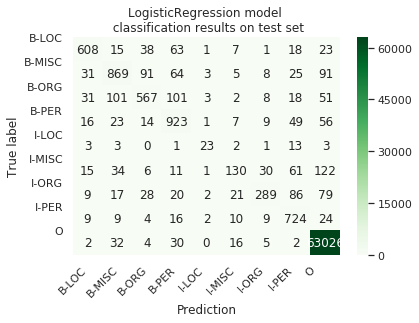

In [0]:
print("Dutch test results " + str(round(du_test_score,5)))
show_confusion_matrix(Y_test_du,du_test_predictions)

We can clearly see how relevant are the previus and next word features, in our case their tags.<br>
Spanish test results improvment $0.9447 \to 0.96162$.<br>
Dutch test results improvment $0.95985 \to 0.97509$.<br>
About almost two precent improve. 

#### 3.1.3 

We will check that the BIO tags produced by the tagger is a legal sequence.<br>
The following sequences are illegal:
1. I_X followed by B_Y or O but not B_X (X is not Y)
2. B_X followed by B_X OR I_X 


In [0]:
def count_illegal_and_tot(sent):
    ill_seq = 0 
    tot_seq = 0
    seen_tags = set()
    tags = map(lambda word:word[2],sent)
    for tag in tags:
        if not tag == 'O':
            tot_seq += 1
                            
        if tag == 'B-LOC':
            if 'B-LOC' in seen_tags: ill_seq += 1 # B_X then B_X
            if 'I-LOC' in seen_tags: ill_seq += 1 # B_X followed by I_X
            seen_tags.union({'B-LOC'})
                
        if tag == 'I-LOC':
            if 'B-LOC' not in seen_tags: ill_seq += 1 # I_X not followed by B_X
            seen_tags.union({'I-LOC'})
 
        if tag == 'B-MISC':
            if 'B-MISC' in seen_tags: ill_seq += 1 # B_X then B_X
            if 'I-MISC' in seen_tags: ill_seq += 1 # B_X followed by I_X
            seen_tags.union({'B-MISC'})
                
        if tag == 'I-MISC':
            if 'B-MISC' not in seen_tags: ill_seq += 1 # I_X not followed by B_X
            seen_tags.union({'I-MISC'})
                
        if tag == 'B-ORG':
            if 'B-ORG' in seen_tags: ill_seq += 1 # B_X then B_X
            if 'I-ORG' in seen_tags: ill_seq += 1 # B_X followed by I_X
            seen_tags.union({'B-ORG'})
                
        if tag == 'I-ORG':
            if 'B-ORG' not in seen_tags: ill_seq += 1 # I_X not followed by B_X
            seen_tags.union({'I-ORG'})

    return ill_seq,tot_seq
        
def illegal_frequency(data):
    tot_seq = 0
    ill_seq = 0
    for sent in data:
        illegal,tot = count_illegal_and_tot(sent)
        ill_seq += illegal
        tot_seq += tot
        
    return ill_seq / tot_seq
    
 

In [0]:
train_freq = round(illegal_frequency(etrain),3)
dev_freq = round(illegal_frequency(etesta),3)
test_freq = round(illegal_frequency(etestb),3)
print('BIO tags errors frequencies for train {},dev {} and test {}'.format(train_freq,dev_freq,test_freq))

BIO tags errors frequencies for train 0.308,dev 0.311 and test 0.321


About 31% illegal BIO tags, for train dev and test. 

### 3.2 Using Word Embeddings

In [0]:
class EmbeddingsExtractor(TransformerMixin):
  def __init__(self, embedding_model):
    self.emb_model = embedding_model
    self.vocabulary = set(embedding_model.index2word)
    self.size = embedding_model.syn0.shape[1]
  
  def transform(self,X):
    all_features = []
    for s in X:
        all_features += self.sent2features(s)
    return all_features

  def fit(self,X,y=None):
    return self
  
  def sent2features(self,sent):
    return [self.word2featuresEmbedding(sent, i) for i in range(len(sent))]
  
  
  def word2featuresEmbedding(self, sent, i):
    # if a word is not exsist in the vocabulary the embedding would be zeros
    embedding = np.zeros((3*self.size,))
    
    # pre word embedding
    if i > 0 and sent[i-1][0] in self.vocabulary:
        embedding[:self.size] = self.emb_model[sent[i-1][0]]
        
    # word embedding
    if sent[i][0] in self.vocabulary:
        embedding[self.size:2*self.size] = self.emb_model[sent[i][0]]
        
    # next word embedding
    if i < len(sent) - 1 and sent[i+1][0] in self.vocabulary:
        embedding[2*self.size:] = self.emb_model[sent[i+1][0]]
        
    return embedding

In [0]:
def create_pipeline(emb_model):
  return Pipeline([
      ('get_features', FeatureUnion([
          ('like_before', Pipeline([('extract_features', NER_Features()),
                                    ('vectorize', DictVectorizer())])),
          ('word_embeddings', EmbeddingsExtractor(emb_model))
      ]))
  ])

We use the optimal ```C``` we got from the last section whith was $100$ for both langages



In [0]:
# def precision_recall_fscore(clf, le, test):
def get_stats(pred, y):
    stats_labels = {}
    for label in set(y):
        TP = ((pred == label) & (y == label)).sum()
        TN = ((pred != label) & (y != label)).sum()
        FP = ((pred == label) & (y != label)).sum()
        FN = ((pred != label) & (y == label)).sum()
        precision = TP / (TP + FP)
        recall = TP / (TP + FN)
        f1_score = 2 * precision * recall / (precision + recall)
        stats_labels[label] = {'Precision': precision, 'Recall': recall, 'F1 Score': f1_score}
    df = pd.DataFrame(stats_labels).sort_values('F1 Score', axis=1).T
    return df[['Precision', 'Recall','F1 Score']]

#### Spanish

In [0]:
es_emb_path = '../data/wiki.es.vec'

es_emb_model = KeyedVectors.load_word2vec_format(es_emb_path, limit=int(985667*0.18)) # 985667 total numbers of vectores
es_emb_model.init_sims(replace=True)

In [0]:
pipeline = create_pipeline(es_emb_model)
label_encoder = encode_labels(etrain)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  """


In [0]:
X_train_esp = pipeline.fit_transform(etrain)
Y_train_esp = label_encoder.fit_transform(extract_labels(etrain))

X_dev_esp = pipeline.transform(etesta)
Y_dev_esp = label_encoder.transform(extract_labels(etesta))

X_test_esp = pipeline.transform(etestb)
Y_test_esp = label_encoder.transform(extract_labels(etestb))

In [0]:
es_clf = LogisticRegression(C=es_optimal_c,solver='warn',multi_class='auto').fit(X_train_esp, Y_train_esp)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [0]:
print('Spanish model with embedding score on dev: ' + str(round(es_clf.score(X_dev_esp, Y_dev_esp), 5)))
print('Spanish model with embedding score on test: ' + str(round(es_clf.score(X_test_esp, Y_test_esp), 5)))

Spanish model with embedding score on dev: 0.94254
Spanish model with embedding score on test: 0.95376


We can see the the embedding didn't improve the results for the Spanish dataset.<br>
The reason might be that we didn't use all the embedding vectors from fastText due to low processing power, we have used the next param: (```limit=int(985667*0.18)```) in order to save memory otherwise running the notebook would cause to a crash. We also used ```init_sims(replace=True)``` for the same reason.<br>
*"replace : bool, optional If True - forget the original vectors and only keep the normalized ones = saves lots of memory!"*
sklearn documentation.

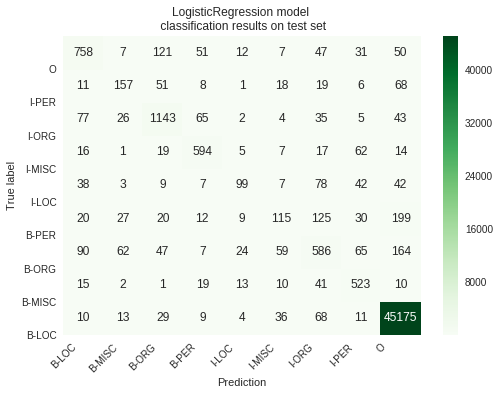

In [0]:
esp_test_predictions = es_clf.predict(X_test_esp)
show_confusion_matrix(Y_test_esp, esp_test_predictions)

In [0]:
get_stats(esp_test_predictions, Y_test_esp)

,Precision,Recall,F1 Score
5,0.437262,0.206463,0.280488
4,0.585799,0.304615,0.400810
1,0.526846,0.463127,0.492936
6,0.576772,0.530797,0.552830
0,0.732367,0.699262,0.715432
7,0.674839,0.824921,0.742370
3,0.769430,0.808163,0.788321
2,0.793750,0.816429,0.804930
8,0.987108,0.996031,0.991550


The index are numbers that do not say much. So let's map them to the labels:

0. B-LOC
1. B-MISC
2. B-ORG
3. B-PER
4. I-LOC
5. I-MISC 
6. I-ORG
7. I-PER
8. O

#### Dutch

In [0]:
nl_emb_path = '../data/wiki.nl.vec'
nl_emb_model = KeyedVectors.load_word2vec_format(nl_emb_path, limit=int(871022*0.2)) # 871022 total numbers of vectores
nl_emb_model.init_sims(replace=True)

In [0]:
pipeline = create_pipeline(nl_emb_model)
label_encoder = encode_labels(dtrain)

X_train_du = pipeline.fit_transform(dtrain)
Y_train_du = label_encoder.fit_transform(extract_labels(dtrain))

X_dev_du = pipeline.transform(dtesta)
Y_dev_du = label_encoder.transform(extract_labels(dtesta))

X_test_du = pipeline.transform(dtestb)
Y_test_du = label_encoder.transform(extract_labels(dtestb))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  """


In [0]:
du_clf = LogisticRegression(C=du_optimal_c,solver='warn',multi_class='auto').fit(X_train_du, Y_train_du)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [0]:
print('Dutch model with embedding score on dev: ' + str(round(du_clf.score(X_dev_du, Y_dev_du), 5)))
print('Dutch model with embedding score on test: ' + str(round(du_clf.score(X_test_du, Y_test_du), 5)))

Dutch model with embedding score on dev: 0.96951
Dutch model with embedding score on test: 0.97593


We can observed a little increase of accuracy from section 3.2.1 on the test set. From 97.509% to 96.951%. Notice that, the percentages are very high already, so this increase is significant.

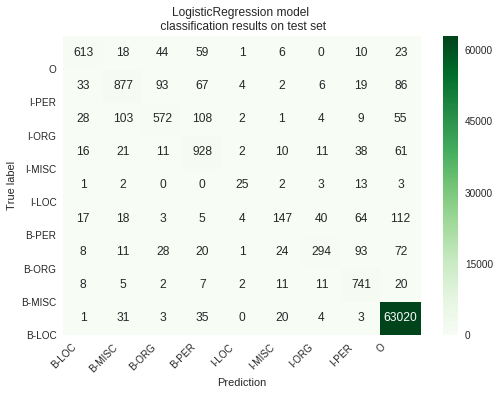

In [0]:
du_test_predictions = du_clf.predict(X_test_du)
show_confusion_matrix(Y_test_du, du_test_predictions)

In [0]:
get_stats(du_test_predictions, Y_test_du)

,Precision,Recall,F1 Score
5,0.659193,0.358537,0.464455
4,0.609756,0.510204,0.555556
6,0.788204,0.533575,0.636364
2,0.756614,0.648526,0.698413
1,0.807551,0.738837,0.771667
3,0.755085,0.845173,0.797593
0,0.845517,0.791990,0.817879
7,0.748485,0.918216,0.824708
8,0.993192,0.998463,0.995820


The index are numbers that do not say much. So let's map them to the labels:

0. B-LOC
1. B-MISC
2. B-ORG
3. B-PER
4. I-LOC
5. I-MISC 
6. I-ORG
7. I-PER
8. O